## Import Library

In [ ]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import demoji
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from wordcloud import WordCloud
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Preparing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Cyber For Ai/cyberbullying_tweets.csv')
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


Let's see all label ! both in value_counts function and visualization 🧐

In [ ]:
data.cyberbullying_type.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
fig = px.bar(data.cyberbullying_type.value_counts(), color_discrete_sequence=px.colors.qualitative.Pastel1, custom_data=[data.cyberbullying_type.value_counts()])
fig.update_traces(hovertemplate='<br><b>Total: </b>%{customdata[0]}')
fig.update_layout(title='Cyberbullying types',
                 template='simple_white',
                 hovermode='x unified',
                 xaxis=dict(title='Type'),
                 yaxis=dict(title='Count'),
                 showlegend=False)
fig.show()

This dataset has equally label! 😊

Check whether there are null values

In [ ]:
data.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

There is no sum value so let's do Data cleaning

## Data Cleaning

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# For lemmatize word
lemma = WordNetLemmatizer()
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['im', 'wa', 'p', 't', 's', 'o', 'e', 'like'])

def clean_text(text):
    
    # Remove Hashtag, Mention, https, www.asdfd, dsfadsf.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Lemmatize word
    text = " ".join([lemma.lemmatize(word) for word in text.split()])
    
    # Remove Punctuation
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    
    # Remove stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
    # Convert emoji to word
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

This function didn't clean emoji and emoticon 

In [ ]:
data['tweet_text'] = data.tweet_text.apply(lambda text: clean_text(text))
data.head()

,tweet_text,cyberbullying_type
0,word food crapilicious,not_cyberbullying
1,white,not_cyberbullying
2,classy whore red velvet cupcakes,not_cyberbullying
3,gio meh thanks head concerned another angry du...,not_cyberbullying
4,isi account pretending kurdish account islam lies,not_cyberbullying


## EDA

Let's see the WordCloud

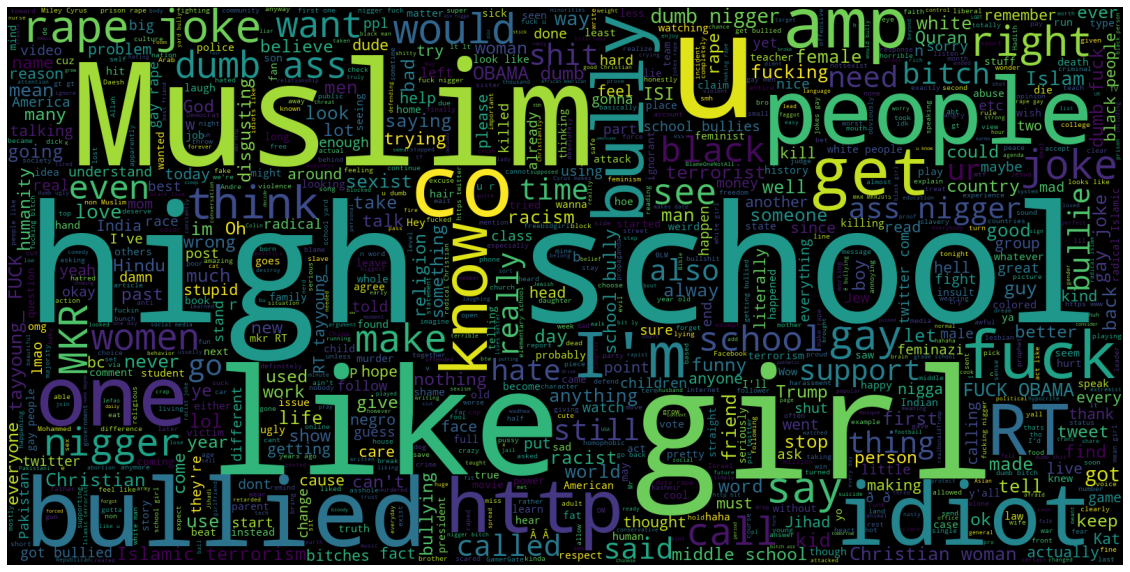

In [ ]:
plt.figure(figsize=(20,20))
STOPWORDS = set(stopwords.words('english'))
wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(" ".join(data.tweet_text)))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Let's see top word for each cyberbullying type!

In [ ]:
for cyber_type in data.cyberbullying_type.unique():
    
    top50_word = data.tweet_text[data.cyberbullying_type==cyber_type].str.split(expand=True).stack().value_counts()[:50]
    
    fig = px.bar(top50_word, color=top50_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top50_word.values])
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    
    fig.update_layout(title=f"Top 50 words for {cyber_type}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()
    
    
    

# **Performing data normalization, feature selection and split data into test and train**

## MACHINE LEARNING

Let's encode "cyberbullying_type" columns to number

In [ ]:
data.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'other_cyberbullying': 3,
             'age': 4,
             'ethnicity': 5}
data['cyberbullying_type'] = data.cyberbullying_type.replace(ENCODE_DICT)
print(data.cyberbullying_type.unique())
data.sample(10)

[0 1 2 3 4 5]


,tweet_text,cyberbullying_type
24362,RT @quan_d88: These ugly ass people be having ...,3
10761,@JamesBolton11 Yup.,1
39104,You really don't. It's impossible to keep anyt...,4
28195,@Symbo1ics apple mostly uses bsd licensed code.,3
33645,"Baby girl, embrace the GINGER I got bullied in...",4
37664,This interview with trump reminds me of my gra...,4
38389,they are the school yard bullies who enjoyed b...,4
8014,pimps up pimps up hoes down Future voice,1
14118,@cyntheiamorris @prettyugly95 are you serious?...,1
45115,@NiqueBlanton @SowaTheArrogant ... Sorry to ca...,5


In [ ]:
data.tweet_text[data.cyberbullying_type == 1].sample(10)

14658    RT @KrisTRealest @Matt_Camps Sum things jus ar...
13329    These are the same piece of shit people who ma...
9954     RT @_dantomlinson: I'm not sexist but girls pl...
13133    So you're sexist AND have no taste. @_ChrisNic...
14192    The smell of delusion is in the air. Just bc y...
15434    So @Schwarziest got suspended from @twitter ag...
13713    @SumbelinaZ @TIB2016 @IronmanL1 @Hatewatch You...
15033    Is anyone watching Family Guy? Gay jokes and s...
15386    Kevin Hart’s Get Hard Is a “Two-Hour Joke That...
11163    why do bitches get mad when you just call them...
Name: tweet_text, dtype: object

Specify variable for X (Data for train and pred) and y(Label)

### CountVectorizer

In [ ]:
# Create word vector (count)
CountVector = CountVectorizer(max_features=2000)

X = CountVector.fit_transform(data.tweet_text).toarray()
y = data.cyberbullying_type.values

print(X.shape, y.shape)

(47692, 2000) (47692,)


Split data to train and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=555)

print(f"X train data has shape {X_train.shape} and their label's shape {y_train.shape}")
print(f"X test data has shape {X_test.shape} and their label's shape {y_test.shape}")

X train data has shape (38153, 2000) and their label's shape (38153,)
X test data has shape (9539, 2000) and their label's shape (9539,)


Predict using RandomForest

In [ ]:
rf = RandomForestClassifier(random_state=555)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=555)

In [ ]:
y_pred = rf.predict(X_test)
print('Accuracy : %f' %(accuracy_score(y_pred, y_test)))

Accuracy : 0.817381


### TfidfVectorizer

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, min_df=.0005, max_df=.8)
X = tfidf.fit_transform(data.tweet_text).toarray()
y = data.cyberbullying_type.values

print(X.shape, y.shape)

(47692, 3293) (47692,)


Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=555)

print(f"X train data has shape {X_train.shape} and their label's shape {y_train.shape}")
print(f"X test data has shape {X_test.shape} and their label's shape {y_test.shape}")

X train data has shape (38153, 3293) and their label's shape (38153,)
X test data has shape (9539, 3293) and their label's shape (9539,)


Prediction using some algorithims and Clasifiers



In [ ]:
rf = RandomForestClassifier(random_state=555)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=555)

In [ ]:
y_pred = rf.predict(X_test)
print('Accuracy : %f' %(accuracy_score(y_pred, y_test)))

Accuracy : 0.820107


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [ ]:
# Support Vector Machine (SVM) classifier
svm = SVC()
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
print("SVM classifier accuracy:", svm_score)

KeyboardInterrupt: ignored

In [ ]:
# k-Nearest Neighbors (KNN) classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print("KNN classifier accuracy:", knn_score)

In [ ]:
# Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print("Decision Tree classifier accuracy:", dt_score)